#Kickstarter Prediction Project

The goal of this project is to be able to successfully predict the amount of money per donater a kickstarter project will receive.

The input in this problem will be the given data, including length of name, category, total length of project, goal amount, number of backers, and country. This will give us a total of 5 different features, and although not a lot, will let us learn more about neural networks and data analysis. 

In [0]:
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

! ls -a /root/.kaggle

! kaggle datasets download -d kemical/kickstarter-projects

! unzip kickstarter-projects.zip

Download 100%.
.  ..  kaggle.json
 52% 19.0M/36.8M [00:03<00:08, 2.19MB/s]
100% 36.8M/36.8M [00:03<00:00, 11.1MB/s]
Archive:  kickstarter-projects.zip
  inflating: ks-projects-201612.csv  
  inflating: ks-projects-201801.csv  


In [0]:
#Upload the future_encoders.py file
def upload_files():  
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

upload_files()

Saving future_encoders.py to future_encoders.py


['future_encoders.py']

In [0]:
import pandas as pd

project_data = pd.read_csv("ks-projects-201801.csv")

project_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [0]:
project_data.shape

(378661, 15)

In [0]:
project_names = project_data["name"].unique()

In [0]:
name_dicts = {} 
keys = range(2000)
values = project_names
for i in keys:
        name_dicts[i] = values[i]
print(name_dicts)

{0: 'The Songs of Adelaide & Abullah', 1: 'Greeting From Earth: ZGAC Arts Capsule For ET', 2: 'Where is Hank?', 3: 'ToshiCapital Rekordz Needs Help to Complete Album', 4: 'Community Film Project: The Art of Neighborhood Filmmaking', 5: 'Monarch Espresso Bar', 6: 'Support Solar Roasted Coffee & Green Energy!  SolarCoffee.co', 7: 'Chaser Strips. Our Strips make Shots their B*tch!', 8: 'SPIN - Premium Retractable In-Ear Headphones with Mic', 9: 'STUDIO IN THE SKY - A Documentary Feature Film (Canceled)', 10: 'Of Jesus and Madmen', 11: 'Lisa Lim New CD!', 12: 'The Cottage Market', 13: 'G-Spot Place for Gamers to connect with eachother & go pro!', 14: 'Tombstone: Old West tabletop game and miniatures in 32mm.', 15: 'Survival Rings', 16: 'The Beard', 17: 'Notes From London: Above & Below', 18: "Mike Corey's Darkness & Light Album", 19: 'Boco Tea', 20: 'CMUK. Shoes: Take on Life Feet First.', 21: 'MikeyJ clothing brand fundraiser', 22: 'Alice in Wonderland in G Minor', 23: 'Mountain brew: A q

In [0]:
sample_incomplete_rows = project_data[project_data.isnull().any(axis=1)].head() #We only have 5 rows of data that we will remove when splitting our data
sample_incomplete_rows

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00


In [0]:
sample_incomplete_rows.shape

project_data.fillna(0)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [0]:
project_data.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [0]:
import numpy as np

project_data['money/person'] = project_data['backers'] / project_data['usd_pledged_real'] ## creating the money per person feature

pd.to_datetime(project_data['deadline'])
pd.to_datetime(project_data['launched'])

project_data['deadline'] = project_data['deadline'].astype('datetime64[ns]')
project_data['launched'] = project_data['launched'].astype('datetime64[ns]')

project_data.dtypes

project_data['time_taken'] = project_data['deadline'].sub(project_data['launched'], axis =0)

project_data['time_taken'] = project_data['time_taken'] / np.timedelta64(1, 'D') ## time taken to complete goal feature creation

project_data['name_length'] = project_data['name'].str.len() ## length of name feature creation

project_data['success'] = project_data['usd_pledged_real']/project_data['usd_goal_real'] ## creating our y-variable 

project_data.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
money/person               float64
time_taken                 float64
name_length                float64
success                    float64
dtype: object

In [0]:
corr_matrix = project_data.corr()
corr_matrix['success'].sort_values(ascending=False)

success             1.000000
backers             0.016605
usd_pledged_real    0.009006
pledged             0.008645
usd pledged         0.006484
time_taken          0.000395
name_length        -0.000096
usd_goal_real      -0.000449
goal               -0.000472
ID                 -0.000838
money/person       -0.002795
Name: success, dtype: float64

In [0]:
project_data['category'].unique()

array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'Childrenswear', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Accessories', 'Rock', 'Hardware',
       'Software', 'Weaving', 'Gadgets', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       

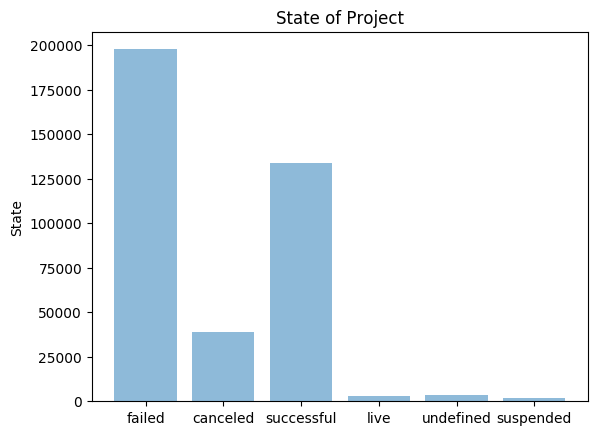

Counter({'failed': 197719, 'successful': 133956, 'canceled': 38779, 'undefined': 3562, 'live': 2799, 'suspended': 1846})


In [0]:
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

c = Counter(project_data['state'])

labels = []
sizes = []

for k,v in c.items():
    labels.append(k)
    sizes.append(v)
 
plt.bar(labels, sizes, align='center', alpha=0.5)
plt.title('State of Project')
 
plt.show()

print(c)

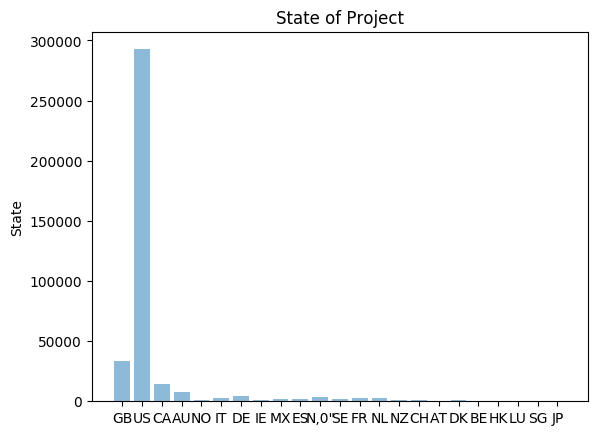

Counter({'US': 292627, 'GB': 33672, 'CA': 14756, 'AU': 7839, 'DE': 4171, 'N,0"': 3797, 'FR': 2939, 'IT': 2878, 'NL': 2868, 'ES': 2276, 'SE': 1757, 'MX': 1752, 'NZ': 1447, 'DK': 1113, 'IE': 811, 'CH': 761, 'NO': 708, 'HK': 618, 'BE': 617, 'AT': 597, 'SG': 555, 'LU': 62, 'JP': 40})


In [0]:
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

c = Counter(project_data['country'])

labels = []
sizes = []

for k,v in c.items():
    labels.append(k)
    sizes.append(v)
 
plt.bar(labels, sizes, align='center', alpha=0.5)
plt.ylabel('Number of Projects')
plt.title('Countries')
 
plt.show()

print(c)

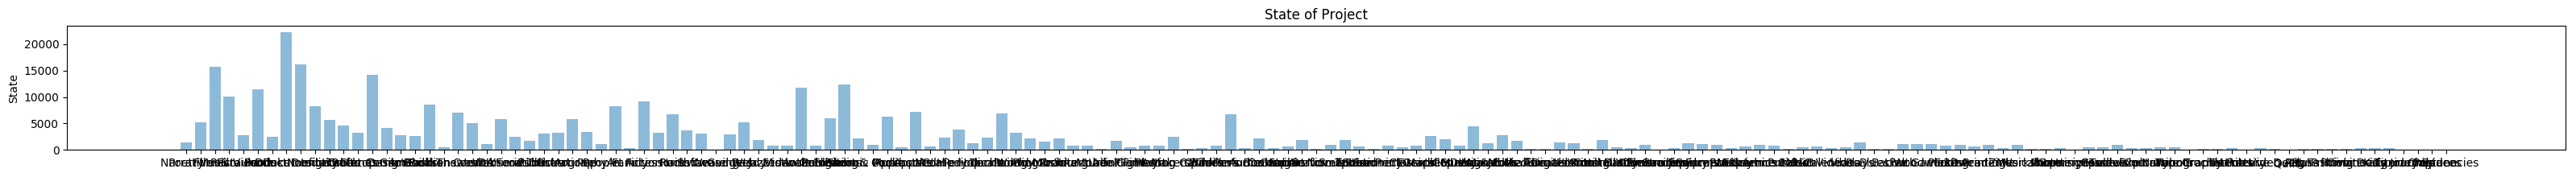

Counter({'Product Design': 22314, 'Documentary': 16139, 'Music': 15727, 'Tabletop Games': 14180, 'Shorts': 12357, 'Video Games': 11830, 'Food': 11493, 'Film & Video': 10108, 'Fiction': 9169, 'Fashion': 8554, 'Nonfiction': 8318, 'Art': 8253, 'Apparel': 7166, 'Theater': 7057, 'Technology': 6930, 'Rock': 6758, "Children's Books": 6756, 'Apps': 6345, 'Publishing': 6018, 'Webseries': 5762, 'Photography': 5752, 'Indie Rock': 5657, 'Narrative Film': 5188, 'Web': 5153, 'Comics': 4996, 'Crafts': 4664, 'Country & Folk': 4451, 'Design': 4199, 'Hip-Hop': 3912, 'Hardware': 3663, 'Pop': 3350, 'Painting': 3294, 'Games': 3226, 'Illustration': 3175, 'Accessories': 3165, 'Public Art': 3077, 'Software': 3048, 'Gadgets': 2965, 'Restaurants': 2819, 'Mixed Media': 2757, 'Comic Books': 2743, 'Art Books': 2676, 'Classical Music': 2613, 'Animation': 2541, 'Playing Cards': 2497, 'Drinks': 2422, 'Dance': 2322, 'Comedy': 2320, 'Drama': 2179, 'Electronic Music': 2170, 'Performance Art': 2154, 'World Music': 2102, 

In [0]:
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

c = Counter(project_data['category'])

labels = []
sizes = []

for k,v in c.items():
    labels.append(k)
    sizes.append(v)
    
fig = plt.figure(figsize=(40, 2))
plt.bar(labels, sizes, align='center', alpha=0.5)
plt.ylabel('State')
plt.title('State of Project')
 
plt.show()

print(c)

#Clean Data

In [0]:
from sklearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from future_encoders import OneHotEncoder

class ColumnSelector(BaseEstimator, TransformerMixin): #This is a column selector function that I wrote to select which features I want to keep in my data when running it through the pipeline
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
       assert isinstance(X, pd.DataFrame)

       try:
            return X[self.columns]
       except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame doesn't include the columns: %s" % cols_error)
            
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
    
cat_attribs = ["category", "country", "currency"] #We are selecting only our position data to be encoded.

cols = ["backers", "usd_pledged_real", "time_taken", "name_length", "money/person", "usd_goal_real" ]  

pipeline = Pipeline([
    ('column_selector', ColumnSelector(columns =  cols))
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

from sklearn.pipeline import FeatureUnion 

full_pipeline = FeatureUnion(transformer_list=[
    ('pipeline', pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [0]:
category_data = project_data['category']
success_data = project_data['success']
original_data = project_data
project_data = full_pipeline.fit_transform(project_data.fillna(0))

print(project_data.shape)

(378661, 202)


In [0]:
#Here we will be splitting the data into a train and test set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in split.split(project_data, category_data):
    print('Training samples: {}, testing samples: {}'.format(train_index.shape, test_index.shape))
    
strat_train_set = project_data[train_index]
strat_test_set = project_data[test_index]

train_success = success_data.loc[train_index]
test_success = success_data.loc[test_index]

print("The initial train set shape is: ",strat_train_set.shape)

print("The initial test set shape is: ",strat_test_set.shape)

prepared_train_set = strat_train_set.take(range(0,1000), axis=0)
prepared_test_set = strat_test_set.take(range(0,500), axis=0)

train_set_target = train_success.take(range(0,1000), axis=0)
test_set_target = test_success.take(range(0,500), axis=0)

print("The final train set shape is: ",prepared_train_set.shape)

print("The final test set shape is: ",prepared_test_set.shape)

print("The final target train shape is: ",train_set_target.shape)
print("The final target test shape is: ",test_set_target.shape)

Training samples: (302928,), testing samples: (75733,)
The initial train set shape is:  (302928, 202)
The initial test set shape is:  (75733, 202)
The final train set shape is:  (1000, 202)
The final test set shape is:  (500, 202)
The final target train shape is:  (1000,)
The final target test shape is:  (500,)


#Verify Our Data Clean

In [0]:
print(strat_train_set[:5])

[[3.00000000e+00 1.00000000e+02 2.86588773e+01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [4.00000000e+00 9.00000000e+01 2.96476968e+01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [4.10000000e+01 2.49000000e+03 4.92445602e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [2.00000000e+00 5.66000000e+00 2.99138079e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+01 7.70000000e+02 2.91650694e+01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [0]:
train_set_target.head()

107515    100.000000
362131      0.180000
30074       1.245000
334495      0.000135
40454       0.077000
Name: success, dtype: float64

In [0]:
original_data.loc[train_index].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,money/person,time_taken,name_length,success
107515,1546616845,"""Life after Exploited"", Dreams are seeds of in...",Art,Art,USD,2012-06-09,1.0,2012-05-11 08:11:13,100.00,successful,3,US,100.00,100.00,1.00,0.030000,28.658877,56.0,100.000000
362131,915210169,BAWSEBROS TRAVELING COSTS,Hip-Hop,Music,USD,2016-02-20,500.0,2016-01-21 08:27:19,90.00,failed,4,US,90.00,90.00,500.00,0.044444,29.647697,25.0,0.180000
30074,1152885247,Take Flight Campaign: Hannah Glavor EP Project...,Music,Music,USD,2011-07-18,2000.0,2011-07-13 01:48:47,2490.00,successful,41,US,2490.00,2490.00,2000.00,0.016466,4.924456,57.0,1.245000
334495,773929569,BeKind app,Apps,Technology,AUD,2014-08-23,45000.0,2014-07-24 02:04:07,6.06,failed,2,AU,5.68,5.66,42020.73,0.353357,29.913808,10.0,0.000135
40454,1205756045,Tall And Curvy,Apparel,Fashion,USD,2015-03-25,10000.0,2015-02-23 20:02:18,770.00,failed,10,US,770.00,770.00,10000.00,0.012987,29.165069,14.0,0.077000


In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(prepared_train_set, train_set_target)

predictions = lin_reg.predict(prepared_train_set)

from sklearn.metrics import mean_squared_error
import numpy as np

# compute RMSE for training set (training error)
lin_mse = mean_squared_error(train_set_target, predictions)
lin_rmse = np.sqrt(lin_mse)
print("The baseline Linear RMSE is: ",lin_rmse)

The baseline Linear RMSE is:  92.92318974174289


In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(prepared_train_set, train_set_target)

predictions = tree_reg.predict(prepared_train_set)

tree_mse = mean_squared_error(train_set_target, predictions)
tree_rmse = np.sqrt(tree_mse)
print("The baseline Tree RMSE is: ",tree_rmse)

#As expected the error is very low due to overfitting

The baseline Tree RMSE is:  9.228363127288618e-05


In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(prepared_train_set, train_set_target)

predictions = forest_reg.predict(prepared_train_set)

forest_mse = mean_squared_error(train_set_target, predictions)
forest_rmse = np.sqrt(forest_mse)
print("The baseline Forest RMSE is: ",forest_rmse)

The baseline Forest RMSE is:  49.39299692801638


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
#Seeing as the random forest regressor returned the least amount of error we use that for tuning
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [30, 50, 70, 100], 'max_features': [2, 10, 15, 20, 30, 50, 75, 100, 150, 200]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [0]:
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(prepared_train_set, train_set_target)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [30, 50, 70, 100], 'max_features': [2, 10, 15, 20, 30, 50, 75, 100, 150, 200]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
grid_search.best_params_ 

print(grid_search.best_params_)

#These will be used for our final evaluation

{'max_features': 15, 'n_estimators': 100}


In [0]:

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

98.48062713858292 {'max_features': 2, 'n_estimators': 30}
98.18110974264634 {'max_features': 2, 'n_estimators': 50}
98.25148341732313 {'max_features': 2, 'n_estimators': 70}
97.86438109568691 {'max_features': 2, 'n_estimators': 100}
97.97128854446625 {'max_features': 10, 'n_estimators': 30}
98.10444357387168 {'max_features': 10, 'n_estimators': 50}
97.70581539755221 {'max_features': 10, 'n_estimators': 70}
97.41978061376966 {'max_features': 10, 'n_estimators': 100}
98.86533776570218 {'max_features': 15, 'n_estimators': 30}
98.39969678553501 {'max_features': 15, 'n_estimators': 50}
97.67779172173196 {'max_features': 15, 'n_estimators': 70}
97.32509486705924 {'max_features': 15, 'n_estimators': 100}
102.87926175453266 {'max_features': 20, 'n_estimators': 30}
100.24785173868422 {'max_features': 20, 'n_estimators': 50}
99.01965297096898 {'max_features': 20, 'n_estimators': 70}
97.89626039816584 {'max_features': 20, 'n_estimators': 100}
100.58626748886772 {'max_features': 30, 'n_estimators'

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances
attributes = cat_attribs + cols
print(sorted(zip(feature_importances, attributes), reverse=True))

[(0.3252716776089924, 'time_taken'), (0.18775294516672258, 'category'), (0.13667996871478513, 'country'), (0.09085603699352822, 'currency'), (0.07474330847120823, 'usd_pledged_real'), (0.05312906745039026, 'backers'), (2.865302465518152e-05, 'usd_goal_real'), (1.0169704844269525e-05, 'name_length'), (7.089960474307341e-06, 'money/person')]


In [0]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(prepared_test_set)
final_mse = mean_squared_error(test_set_target, final_predictions)
final_rmse = np.sqrt(final_mse)
print("The final RMSE or our baseline is: ", final_rmse)

The final RMSE or our baseline is:  123.09515953602371


In [0]:
import keras
keras.__version__

import tensorflow as tf
from keras import models
from keras import layers

  
def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
  
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(prepared_train_set.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1)) #no other constraint because we want it to be linear
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    
    return model

Using TensorFlow backend.


In [0]:
num_epochs = 1500
num_batch = 256
all_mae_histories = []


for i in range(10):
  
    # Building model
    model = build_model()
    # Train the model
    history = model.fit(prepared_train_set, train_set_target,
                        epochs=num_epochs, batch_size=num_batch, verbose=0)

    
    mae_history = history.history['mean_absolute_error']
    all_mae_histories.append(mae_history)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


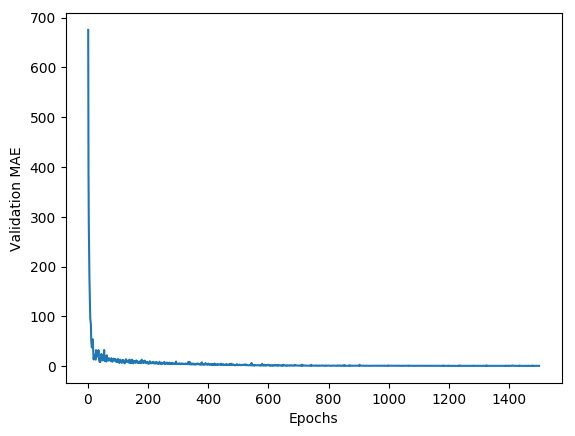

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

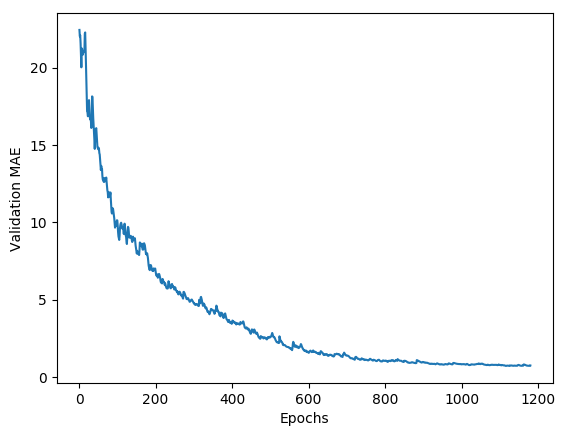

In [0]:
#Smoothing our curve to be able to see exactly where we are overfitting
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[20:1200])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [0]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(prepared_train_set, train_set_target,
          epochs=400, batch_size=128, verbose=0)
train_mse_score, train_mae_score = model.evaluate(prepared_train_set, train_set_target)

print("The train mae score for a 6 layer 16 node network is: ", train_mae_score)


model = build_model()
# Train it on the entirety of the data.
model.fit(prepared_train_set, train_set_target,
          epochs=400, batch_size=128, verbose=0)
test_mse_score, test_mae_score = model.evaluate(prepared_test_set, test_set_target)

print("The test mae score for a 6 layer 16 node network is: ", test_mae_score)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1000/1000 [==============================] - 0s 85us/step
The train mae score for a 6 layer 16 node network is:  1.2749652824401856
500/500 [==============================] - 0s 166us/step
The test mae score for a 6 layer 16 node network is:  5.338379226922989


In [0]:
def final_model_test(n_nodes, trainX, trainy, testX, testy):

        n_input, n_classes = 202, 202

        model = models.Sequential()
        model.add(layers.Dense(n_nodes, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
        model.add(layers.Dense(n_nodes, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
        model.add(layers.Dense(1))

        model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
        # fit model on train set
        history = model.fit(trainX, trainy, epochs=100, verbose=0)
        test_mse_score, test_mae_score = model.evaluate(testX, testy)

        return history, test_mae_score

history, result = final_model_test(16, prepared_train_set, train_set_target, prepared_test_set, test_set_target)

print("The error for a 2 layer 16 node network is: ", result)

history1, result1 = final_model_test(32, prepared_train_set, train_set_target, prepared_test_set, test_set_target)

print("The error for a 2 layer 32 node network is: ", result1)

history2, result2 = final_model_test(64, prepared_train_set, train_set_target, prepared_test_set, test_set_target)

print("The error for a 2 layer 64 node network is: ", result2)

500/500 [==============================] - 0s 259us/step
The history for a 2 layer 16 node network is:  <keras.callbacks.History object at 0x7f2070803588> and the error is:  94.92822267150879
500/500 [==============================] - 0s 274us/step
The history for a 2 layer 32 node network is:  <keras.callbacks.History object at 0x7f2070574828> and the error is:  361.77492672729494
500/500 [==============================] - 0s 296us/step
The history for a 2 layer 64 node network is:  <keras.callbacks.History object at 0x7f20702dac50> and the error is:  1141.1270408935547
